# Multibeam Frequency Shifter - https://doi.org/10.1364/OE.498792

Below, one can find a shematic of a 16-by-5 multibeam concept. By applying a wavelike modulation to the modulators, we can mimick acousto optic like modulation characteristics and hereby split the sideband frequencyies towards different directions. A star coupler can collect then these different directions and freqquencies.

<img src="images\shematic_working_priciple.jpg" alt="Image" width="50%" height="50%">

In [2]:
import numpy as np
import gdsfactory as gf

from gdsfactory.cross_section import strip
from gdsfactory.typings import ComponentSpec, CrossSectionSpec, LayerSpec
from gdsfactory.generic_tech import get_generic_pdk

import gplugins.tidy3d as gt
from gplugins.config import PATH
from gplugins import utils
from tidy3d import web
import tidy3d as td
import matplotlib.pyplot as plt
from simulation import get_structures, get_monitors, get_sources, get_sparam, get_wavelengths
from tidy3d.plugins.mode import ModeSolver

gf.config.rich_output()

PDK = get_generic_pdk()
PDK.activate()


2023-08-30 21:44:13.711 | INFO     | gplugins.tidy3d:<module>:61 - Tidy3d '2.3.3' installed at ['c:\\Users\\edieussa\\anaconda3\\envs\\environment\\Lib\\site-packages\\tidy3d']
2023-08-30 21:44:13.847 | INFO     | gdsfactory.technology.layer_views:__init__:810 - Importing LayerViews from YAML file: 'c:\\Users\\edieussa\\anaconda3\\envs\\environment\\Lib\\site-packages\\gdsfactory\\generic_tech\\layer_views.yaml'.
2023-08-30 21:44:13.856 | INFO     | gdsfactory.pdk:activate:317 - 'generic' PDK is now active


## Star Coupler
In order to efficiently collect the sidebands, a star coupler can be used. Here we consider a 16-by-5 frequency shifter and below we show the design of a 16-by-5 star coupler in gdsfactory

#### Aperture
The aperture determines the spreading angle or numerical aperture of the in and outputs. We try to fill this angle as well as possible for the output apertures.



In [3]:
ap = gf.Component("aperture")
P = gf.Path()
P.append(gf.path.straight(length=10))


X1=gf.CrossSection(width=0.5,
                    offset=0,
                    layer='WG',
                    name='wg',
                    sections = [])

X2=gf.CrossSection(width=2,
                    offset=0,
                    layer='WG',
                    name='wg',
                    sections = [])

# Create the transitional CrossSection
Xtrans = gf.path.transition(cross_section1=X1, cross_section2=X2, width_type="sine")
# Create a Path for the transitional CrossSection to follow
P3 = gf.path.straight(length=10., npoints=100)
# Use the transitional CrossSection to create a Component
straight_transition = gf.path.extrude(P3, Xtrans)
ap << straight_transition
aperture_components = {
    "aperture": straight_transition
}
x= straight_transition.rotate(0)

x
scene = x.to_3d()
scene.show()

2023-08-30 21:44:14.411 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?


trimesh: threejs viewer

In [4]:
@gf.cell
def star_coupler(
    num_in: int = 16,
    num_out: int = 5,
    rowland_r: float = 46.25,
    pitch_angle_in: float = 1.64,
    pitch_angle_out: float = 3.76,
    aperture_in: str = "aperture",
    cross_section_ap: CrossSectionSpec = 'strip',
    port_ap_width: float = 2.,
    layer_slab: LayerSpec = 'WG'
    ) -> gf.Component:
    """Free propagation region.
    .. code::
                 length
                 <-->
                   /|
                  / |
           width1|  | width2
                  \ |
                   \|
    """
    length_extension = 3.  # keep minimum 4
    length_straight = 1.

    # aperture in
    angles_in = np.linspace(-(num_in-1)/2*pitch_angle_in,+(num_in-1)/2*pitch_angle_in, num_in)
    yports_in = 2*rowland_r*np.sin(np.deg2rad(angles_in))
    xports_in = rowland_r-2*rowland_r*np.cos(np.deg2rad(angles_in))
    pitch_in = 4.*rowland_r*np.sin(np.deg2rad(pitch_angle_in/2.))

    # apertures out
    angles_out = np.linspace(-(num_out-1)/2.*pitch_angle_out,(num_out-1)/2.*pitch_angle_out, num_out)
    yports_out = rowland_r*np.sin(np.deg2rad(angles_out))
    xports_out = rowland_r*np.cos(np.deg2rad(angles_out))
    pitch_out =  2.*rowland_r*np.sin(np.deg2rad(pitch_angle_out)/2.)

    # create FPR
    extension_in = 5.
    x_polygon_in = xports_in - pitch_in / 2. * np.sin(np.deg2rad(angles_in))
    x_polygon_in = np.append(x_polygon_in, xports_in[-1] + extension_in * np.sin(np.deg2rad(angles_in[-1])))
    x_polygon_in = np.insert(x_polygon_in, 0, xports_in[0] - extension_in * np.sin(np.deg2rad(angles_in[0])),)
    y_polygon_in = yports_in - pitch_in / 2. * np.cos(np.deg2rad(angles_in))
    y_polygon_in = np.append(y_polygon_in, yports_in[-1] + extension_in * np.cos(2*np.deg2rad(angles_in[-1])))
    y_polygon_in = np.insert(y_polygon_in, 0,  yports_in[0] - extension_in * np.cos(2*np.deg2rad(angles_in[0])))

    extension_out = 10.
    x_polygon_out = xports_out + pitch_out / 2. * np.sin(np.deg2rad(angles_out))
    x_polygon_out = np.append(x_polygon_out, xports_out[-1] - extension_out * np.sin(np.deg2rad(angles_out[-1])))
    x_polygon_out = np.insert(x_polygon_out, 0, xports_out[0] + extension_out * np.sin(np.deg2rad(angles_out[0])))
    y_polygon_out = yports_out - pitch_out / 2. * np.cos(np.deg2rad(angles_out))
    y_polygon_out = np.append(y_polygon_out, yports_out[-1] + extension_out * np.cos(np.deg2rad(angles_out[-1])))
    y_polygon_out = np.insert(y_polygon_out, 0,  yports_out[0] - extension_out * np.cos(np.deg2rad(angles_out[0])))

    x_polygon = np.concatenate([x_polygon_in, np.flip(x_polygon_out)])
    y_polygon = np.concatenate([y_polygon_in, np.flip(y_polygon_out)])

    polygon_tuples = []
    for i in range(np.size(x_polygon)):
        polygon_tuples.append((x_polygon[i],y_polygon[i]))

    sc = gf.Component()
    slab = gf.Component()
    slab.add_polygon(polygon_tuples, layer=layer_slab)
    
    aperture_component = aperture_components[aperture_in]
    
    ap_ports = []
    straight_ports = []

    for i, angle_i in enumerate(angles_in):
        slab.add_port(
        f"W{i}",
        center=(xports_in[i],yports_in[i]),
        width = port_ap_width,
        orientation = 180.-angle_i,
        layer=layer_slab
        )
        aperture = sc.add_ref(aperture_component)
        aperture.connect("o2", destination=slab.ports[f"W{i}"])
        slab = gf.geometry.boolean(slab, aperture, operation="A-B", precision=1e-12)
        
        straight_ref = sc << gf.components.straight(length=length_straight, cross_section=cross_section_ap)
        straight_ref.move((aperture.ports["o1"].x-length_extension*np.cos(np.deg2rad(angle_i))-length_extension
                           , aperture.ports["o1"].y+length_extension*np.sin(np.deg2rad(angle_i))))
        
        # to enable ports at the input of the aperture:  
        # sc.add_port(f"o{i}", port=straight_ref.ports["o1"])

        ap_ports.append(aperture.ports["o1"])
        straight_ports.append(straight_ref.ports["o2"])

        # to put ports at the slab input (for simulation) 
        sc.add_port(
        f"W{i}",
        center=(xports_in[i],yports_in[i]),
        width = port_ap_width,
        orientation = 180.-angle_i,
        layer=layer_slab
        )
    
    
    routes = gf.routing.get_bundle_all_angle(ap_ports, straight_ports,cross_section= cross_section_ap)
    for route in routes:
        sc.add(route.references)
    
    ap_port = []
    straight_ports = []

    for i, angle_i in enumerate(angles_out):
        slab.add_port(
        f"E{i}",
        center=(xports_out[i],yports_out[i]),
        width = port_ap_width,
        orientation = angle_i/2.,
        layer=layer_slab
        )
        aperture = sc.add_ref(aperture_component)
        aperture.connect("o2", destination=slab.ports[f"E{i}"])
        slab = gf.geometry.boolean(slab, aperture, operation="A-B", precision=1e-12)

        straight_ref = sc << gf.components.straight(length=length_straight, cross_section=cross_section_ap)
        straight_ref.move((aperture.ports["o1"].x+length_extension*np.cos(np.deg2rad(angle_i/2.))+length_straight, aperture.ports["o1"].y+length_extension*np.sin(np.deg2rad(angle_i/2.))))
        
        # to enable ports at the end of the aperture: 
        #sc.add_port(f"o{i+num_in}", port=straight_ref.ports["o2"])
        ap_port.append(aperture.ports["o1"])
        straight_ports.append(straight_ref.ports["o1"])

        # to enable ports at the slab outputs (for simulation)
        sc.add_port(
        f"E{i}",
        center=(xports_out[i],yports_out[i]),
        width = port_ap_width,
        orientation = angle_i/2.,
        layer=layer_slab
        )

    routes2 = gf.routing.get_bundle_all_angle(straight_ports, ap_port, end_cross_section=cross_section_ap )
    for route2 in routes2:
        sc.add(route2.references)

        

    slab = gf.geometry.offset(slab, distance = 0.1, precision = 1e-9, layer=layer_slab)
    sc.auto_rename_ports()
    sc << slab
    return sc


c = star_coupler()
c.show(show_ports=True)

scene = c.to_3d()
scene.show()


2023-08-30 21:44:19.243 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?
2023-08-30 21:44:19.825 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?


trimesh: threejs viewer

## Simulation of the Star Coupler
The star coupler will be simulated using 2D FDTD with tidy3d.
The source can be changed to different ports. We have done simulations for the 5 output ports acting as a source and saved them in the data folder. (sim_data1,sim_data2,sim_data3,sim_data4,sim_data5). From these simulations the essential s parameters can be calculated (in to output). 

type='ModeSource' center=(47.84790977762995, -6.183996775901308, 0.0) size=(0.0, 3.0, inf) source_time=GaussianPulse(amplitude=1.0, phase=0.0, type='GaussianPulse', freq0=193414489032258.06, fwidth=19341448903225.805, offset=5.0) name='o21' num_freqs=5 direction='+' mode_spec=ModeSpec(num_modes=2, target_neff=None, num_pml=(0, 0), filter_pol=None, angle_theta=3.0759682737148064, angle_phi=0.0, precision='single', bend_radius=None, bend_axis=None, track_freq='central', group_index_step=False, type='ModeSpec') mode_index=1


c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\components\geometry.py:2964: RuntimeWarning: invalid value encountered in scalar multiply
  max_offset += max(0, abs(self._tanq) * self.length_axis / 2)
C:\Users\edieussa\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3508: UserWarning: Component.write_gds_with_metadata() is deprecated. Use Component.write_gds(with_metadata=True) or Component.write_oas(with_metadata=True).
  exec(code_obj, self.user_global_ns, self.user_ns)
2023-08-30 22:18:01.074 | INFO     | gdsfactory.component:_write_library:1909 - Wrote to 'data\\star_coupler.gds'
2023-08-30 22:18:01.888 | INFO     | gdsfactory.component:write_gds_with_metadata:2015 - Write YAML metadata to 'data\\star_coupler.yml'


WindowsPath('data/star_coupler.gds')

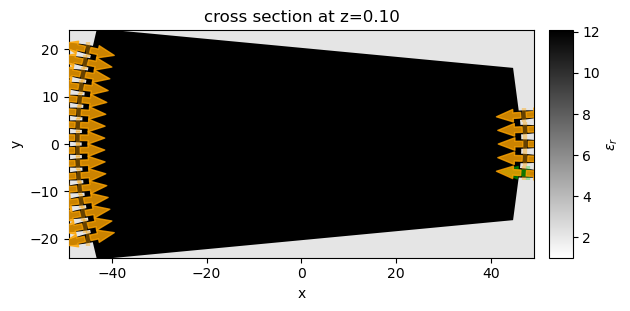

In [16]:
rowland_r=46.25
c = star_coupler(rowland_r=rowland_r)
#print(c.ports)
size = [2*rowland_r+5.,rowland_r+1.,0]

structures = get_structures(c, is_3d=False)
monitors = get_monitors(c, is_3d=False, domain_size=size, monitor_offset=1.0)


sources = get_sources(c,is_3d=False,port_source_names=["o21"], source_offset=2.0,num_modes=2,mode_index=1)
# we take mode_index = 1 since this will be TE mode as seen from the modesolver (see next)

print(sources)
sim = td.Simulation(
    size = size,
    structures= structures,
    sources=[sources],
    monitors=monitors,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=1.55),
    run_time=1e-11,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.periodic()),
    shutoff=1e-9
    )

sim.plot_eps(z=0.1, freq=td.C_0/1.55)
freq0=td.C_0/1.55
c.write_gds_with_metadata(gdsdir = "data/")


We can check the modes with the modesolver and we see that mode_index=1 is TE

[21:25:35] WARNING: Use the remote mode solver with subpixel averaging for better accuracy       ]8;id=816529;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\plugins\mode\mode_solver.py\mode_solver.py]8;;\:]8;id=934198;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\plugins\mode\mode_solver.py#125\125]8;;\
           through 'tidy3d.plugins.mode.web.run(...)'.                                                             

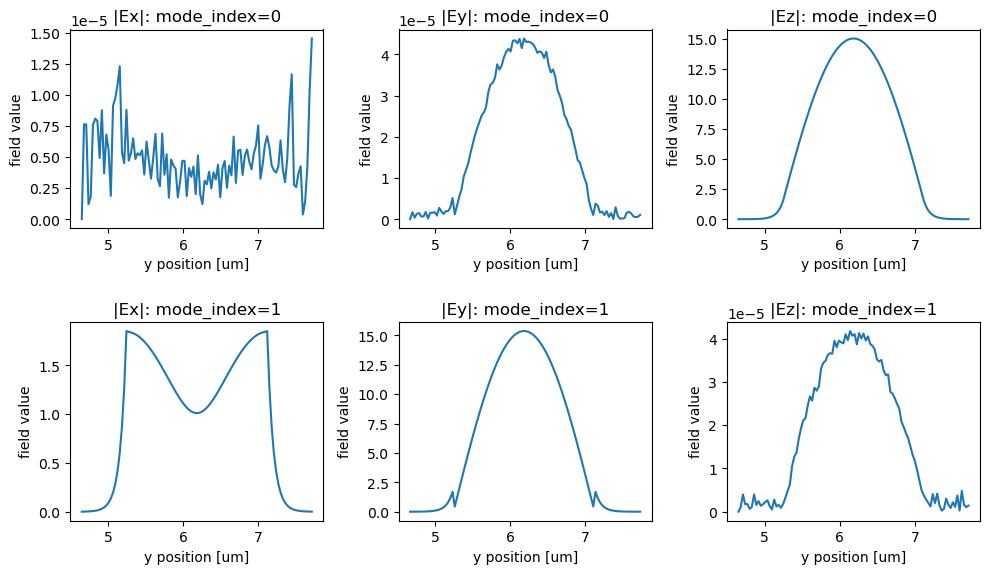

In [5]:

ms = ModeSolver(
    simulation=sim, plane=sources.geometry, mode_spec=sources.mode_spec, freqs=[td.C_0/1.55]
)
modes = ms.solve()

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    2, 3, tight_layout=True, figsize=(10, 6)
)
modes.Ex.sel(mode_index=0, f=freq0).abs.plot(ax=ax1)
modes.Ey.sel(mode_index=0, f=freq0).abs.plot(ax=ax2)
modes.Ez.sel(mode_index=0, f=freq0).abs.plot(ax=ax3)
modes.Ex.sel(mode_index=1, f=freq0).abs.plot(ax=ax4)
modes.Ey.sel(mode_index=1, f=freq0).abs.plot(ax=ax5)
modes.Ez.sel(mode_index=1, f=freq0).abs.plot(ax=ax6)
ax1.set_title("|Ex|: mode_index=0")
ax2.set_title("|Ey|: mode_index=0")
ax3.set_title("|Ez|: mode_index=0")
ax4.set_title("|Ex|: mode_index=1")
ax5.set_title("|Ey|: mode_index=1")
ax6.set_title("|Ez|: mode_index=1")
plt.show()


The code below uploads the simulation task to tidy and executes the simulation after which the data is loaded in the data folder. Note that suitable setup of your tidy3d account and credentials is necessary to execute. Running this code is owver not necessary since the simulation results are already in the data folder.

In [17]:
task_id = web.upload(sim, task_name="sim_o21")
print("Max flex unit cost: ", web.estimate_cost(task_id))
web.start(task_id)
web.monitor(task_id, verbose = True)
print("Billed flex unit cost: ", web.real_cost(task_id))
sim_data = web.load(task_id, path="data/sim_data5.hdf5")


[22:18:09] Created task 'sim_o21' with task_id 'fdve-544d8fd8-af0d-4160-a4ed-2e5deab1f413v1'.         ]8;id=527185;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=339661;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#189\189]8;;\

           View task using web UI at                                                                  ]8;id=949503;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=444055;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#191\191]8;;\
           ]8;id=981723;https://tidy3d.simulation.cloud/workbench?taskId=fdve-544d8fd8-af0d-4160-a4ed-2e5deab1f413v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=808109;https://tidy3d.simulation.cloud/workbench?taskId=fdve-544d8fd8-af0d-4160-a4ed-2e5deab1f413v1\taskId]8;;\]8;id=981723;https://tidy3d.simulation.cloud/workbench?taskId=fdve-544d8fd8-af0d-4160-a4ed-2e5deab1f413v1\=]8;;\]8;id=22910;https://tidy3d.simulation.cloud/workbench?taskId=fdve-544d8fd8-af0d-4160-a4ed-2e5deab1f413v1\fdve]8;;\]8;id=981723;https://tidy3d.simulation.cloud/workbench?taskId=fdve-544d8fd8-af0d-4160-a4ed-2e5deab1f413v1\-544d8fd8-af0d-4160-a4ed-2e5deab1f41]8;;\              
           ]8;id=981723;https://tidy3d.simulation.cloud/workbench?taskId=fdve-544d8fd8-af0d-4160-a4ed-2e5deab1f413v1\3v1']8;;\.                                                                                                   

Output()

Max flex unit cost:  0.305396236548959


[22:18:26] status = queued                                                                            ]8;id=976538;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=439379;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#363\363]8;;\

Output()

[22:18:30] status = preprocess                                                                        ]8;id=268984;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=657539;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#357\357]8;;\

[22:18:38] Maximum FlexCredit cost: 0.305. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=367409;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=545227;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#343\343]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=439480;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=439472;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#379\379]8;;\

[22:18:39] running solver                                                                             ]8;id=160173;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=213923;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#389\389]8;;\

           To cancel the simulation, use 'web.delete(task_id)' or delete the task in the web UI.      ]8;id=824984;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=499207;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\
           Terminating the Python script will not stop the job running on the cloud.                               

Output()

[22:21:46] status = postprocess                                                                       ]8;id=79050;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=351420;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#424\424]8;;\

Output()

[22:22:43] status = success                                                                           ]8;id=930014;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=503614;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#431\431]8;;\

[22:22:44] WARNING: Billed FlexCredit for task 'fdve-544d8fd8-af0d-4160-a4ed-2e5deab1f413v1' is not   ]8;id=12194;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=870627;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#778\778]8;;\
           available. If the task has been successfully run, it should be available shortly.                       

Billed flex unit cost:  0.0


Output()

[22:23:26] loading SimulationData from data/sim_data5.hdf5                                            ]8;id=693655;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=78976;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#609\609]8;;\

c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\components\geometry.py:2964: RuntimeWarning: invalid value encountered in scalar multiply
  max_offset += max(0, abs(self._tanq) * self.length_axis / 2)


[22:23:26] WARNING: Simulation final field decay value of 1.92e-07 is greater than the simulation     ]8;id=733413;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=107911;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#616\616]8;;\
           shutoff threshold of 1e-09. Consider simulation again with large run_time duration for                  
           more accurate results.                                                                                  

We can now load the simulation_data of the already performed simulations

In [18]:
sim_data1 = td.SimulationData.from_file(fname='data/sim_data1.hdf5')
sim_data2 = td.SimulationData.from_file(fname='data/sim_data2.hdf5') 
sim_data3 = td.SimulationData.from_file(fname='data/sim_data3.hdf5') 
sim_data4 = td.SimulationData.from_file(fname='data/sim_data4.hdf5') 
sim_data5 = td.SimulationData.from_file(fname='data/sim_data5.hdf5') 
component = gf.read.import_gds(gdspath="data/star_coupler.gds", read_metadata=True)

dict_sim_1 = {}
dict_sim_1['source_port_name']= 'o17'
dict_sim_1['sim_data'] = sim_data1

dict_sim_2 = {}
dict_sim_2['source_port_name']= 'o18'
dict_sim_2['sim_data'] = sim_data2

dict_sim_3 = {}
dict_sim_3['source_port_name']= 'o19'
dict_sim_3['sim_data'] = sim_data3

dict_sim_4 = {}
dict_sim_4['source_port_name']= 'o20'
dict_sim_4['sim_data'] = sim_data4

dict_sim_5 = {}
dict_sim_5['source_port_name']= 'o21'
dict_sim_5['sim_data'] = sim_data5


c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\components\geometry.py:2964: RuntimeWarning: invalid value encountered in scalar multiply
  max_offset += max(0, abs(self._tanq) * self.length_axis / 2)
c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\components\geometry.py:2964: RuntimeWarning: invalid value encountered in scalar multiply
  max_offset += max(0, abs(self._tanq) * self.length_axis / 2)
c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\components\geometry.py:2964: RuntimeWarning: invalid value encountered in scalar multiply
  max_offset += max(0, abs(self._tanq) * self.length_axis / 2)
c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\components\geometry.py:2964: RuntimeWarning: invalid value encountered in scalar multiply
  max_offset += max(0, abs(self._tanq) * self.length_axis / 2)
c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\components\geometry.py:2964: RuntimeWa

We can visuallize this simulation

In [ ]:
# visualize normalization run
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 6))

ax1 = sim_data1.plot_field("field", "Ey", val="real", z=0, ax=ax1)
ax2 = sim_data1.plot_field("field", "E", val="abs", z=0, ax=ax2)
ax1.set_title("Ex")
ax2.set_title("Ey")

plt.show()

Using these simulations we can create a nested list S such that S[i,j,lambda] is the s-parameter from right port i (top to bottom) to port j at wavelength lambda

In [19]:

dict_simulations = [dict_sim_1, dict_sim_2, dict_sim_3, dict_sim_4, dict_sim_5]
ports_out = ['o1','o2', 'o3', 'o4','o5','o6', 'o7', 'o8','o9','o10', 'o11', 'o12','o13','o14', 'o15', 'o16', 'o17','o18', 'o19', 'o20','o21']
wavelengths =  get_wavelengths('o1', dict_sim_1['sim_data'])

num_simulations = len(dict_simulations)
num_ports = len(ports_out)
num_wavelengths = len(wavelengths)

S = np.zeros((num_simulations, num_ports, num_wavelengths),dtype=np.complex128)

for idx_sim, dict_sim in enumerate(dict_simulations):
    source_port_name = dict_sim['source_port_name']
    sim_data = dict_sim['sim_data']
    for idx, port_out in enumerate(ports_out):
        S[idx_sim,idx,:] = get_sparam(port_out, component=component, sim_data = sim_data, mode_index=1)




Now lets plot what happens when the input apertures have similar amplitudes, but we use phase tuning by adding sequential phase differences

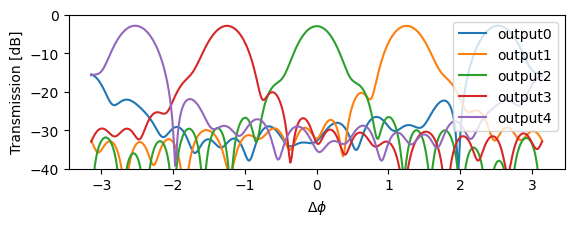

In [22]:
# create function for plotting performance
input_port_index_array = range(0,16)
wavelength_index = 4
_d_phis = np.linspace(-np.pi, np.pi, 361)
def calc_transmission_with_phase_delay(input_port_index_array, output_index, amplitudes, fixed_delays, S, wavelength_index):
    outs = []
    for i in input_port_index_array:
        me = S[output_index,i,wavelength_index]
        phase_delay = i * _d_phis + fixed_delays[i-1]
        outs.append(me * amplitudes[i-1] * np.exp(1j * phase_delay))
    return np.array(sum(outs))

amplitudes=np.ones(16)
amplitudes /= np.sqrt(np.sum(np.square(amplitudes))) # normalization

d_phis = np.linspace(-np.pi, np.pi, 361)
fixed_delays=np.zeros(16)
fig1, ax1 = plt.subplots(figsize = (6.4,2.0))
#plt.matplotlib.rc('text', usetex = True)
#plt.matplotlib.rc('grid', linestyle = 'dotted')
ax1.set_ylim([-40,0])
for i in range(5):
    out_amp=calc_transmission_with_phase_delay(input_port_index_array=input_port_index_array, output_index=i, amplitudes = amplitudes, fixed_delays = fixed_delays, S = S, wavelength_index=wavelength_index)
    ax1.plot(d_phis,10*np.log10(np.abs(out_amp)**2), label="output{}".format(i))
ax1.legend(loc='upper right')
ax1.set_ylabel('Transmission [dB]')
ax1.set_xlabel("$\Delta \phi$")
plt.show()


#for port in range(1,1):
#    out_amp=calc_transmission_with_phase_delay(port, amplitudes, fixed_delays, S)
#    ax1.plot(d_phis,10*np.log10(np.abs(out_amp)**2), label="output{}".format(port))
#    print('Max Power to output {} : {} dB'.format(port,10*np.log10(max(np.abs(out_amp))**2)))
#ax1.legend(loc='upper right')
#ax1.set_ylabel('Transmission [dB]')
#ax1.set_xlabel("$\Delta \phi$")
#plt.show()


## Modulation
Now that we have a simulation of the star coupler, we want to estimate the performance of the multibeam frequency shifter in which a modulation is added to each input of the star coupler and the modulation array is driven in 'wave-like' fashion. Hereby emulating a travelling acoustic wave, which causes the different frequencies to direct towards the different outputs.

First we define a modulation. Lets consider perfect phase modulation. We also create a function to do fourier transform to calculate the amplitude of the harmonics

In [30]:
def perfect_pm_mod(delta,t):
    dphase=delta*np.sin(wm*t)
    pm_mod=amp=10**(-0/20)*np.exp(1j*dphase)
    return t, dphase, pm_mod

def calc_harmonics(x,t,wm,N):
    dt=t[1]-t[0]
    T=t[-1]-t[0]
    N_array=np.linspace(-N,N,2*N+1)
    A_array=np.zeros(2*N+1,dtype='complex')
    
    for idx, n in enumerate(N_array):
        An=np.trapz(x*np.exp(-1j*n*wm*t),dx=dt)*1/T
        A_array[idx]=An

    return N_array, A_array



Now we can plot the harmonic amplitude versus the modulation depth delta. As expected this follows the first order Bessel functions

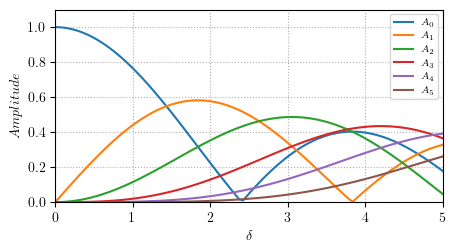

In [31]:

# time array
fs = 10e3 # Sampling rate [Hz]
dt=1/fs
t = np.arange(start=0, stop = 1, step = dt)

# modulation
fm=100  # [Hz] modulation frequency
wm=2*np.pi*fm # angular frequency [Hz]


delta_array=np.linspace(0,5,100)
N=5
AmplitudeHarmonics=np.zeros((len(delta_array),2*N+1))

for idx, delta in enumerate(delta_array):
    t, dphas, pm = perfect_pm_mod(delta ,t)
    N_array, H_array = calc_harmonics(pm,t,wm,N)
    AmplitudeHarmonics[idx]=np.abs(H_array)


fig, ax =plt.subplots()
plt.matplotlib.rc('text', usetex = True)
plt.matplotlib.rc('grid', linestyle = 'dotted')
plt.matplotlib.rc('figure', figsize = (5,2.5)) # (width,height) inches
x = delta_array
for v in range(0, 6):
    ax.plot(x, np.abs(AmplitudeHarmonics[:,N+v]))
ax.set_xlim((0, 5))
ax.set_ylim((-0., 1.1))
ax.legend(('$A_0$', '$A_1$', '$A_2$',
'$A_3$', '$A_4$', '$A_5$'), loc = 'upper right',prop={'size': 7})
plt.xlabel('$\delta$')
plt.ylabel('$Amplitude$')
ax.grid(True)


In [50]:
d_phis = np.linspace(-np.pi, np.pi, 361)
fixed_delays=np.zeros(N) # consecutive delay of modulation

def calc_transmission_harmonics(input_port_index_array, output_index, amplitudes,  harmonic_number, S, wavelength_index):
    outs=[]
    for i in input_port_index_array:
        me = S[output_index, i, wavelength_index]
        phase_delay = harmonic_number * i * _d_phis 
        outs.append(me  * amplitudes[i]* np.exp(1j * phase_delay))
    return np.array(sum(outs))



C:\Users\edieussa\AppData\Local\Temp\ipykernel_62692\3474098507.py:79: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


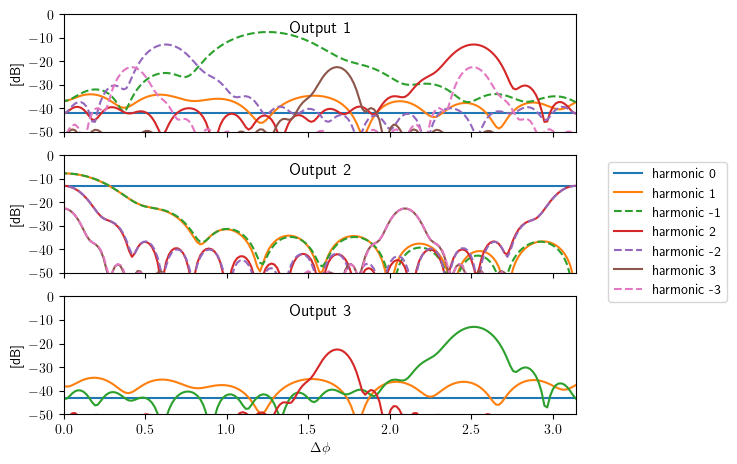

In [51]:
delta_amp=1.84

t,dphase, pm_t = perfect_pm_mod(delta_amp ,t)

Orders = 4
N_harmonics, Am_harmonics = calc_harmonics(pm_t,t,wm,Orders)

amplitudes=np.ones(16)
amplitudes /= np.sqrt(np.sum(np.square(amplitudes))) # normalization

fig, ax = plt.subplots(3,1,sharex='col', sharey='row')

port=1
ax1=ax[0]
plt.matplotlib.rc('text', usetex = True)
plt.matplotlib.rc('grid', linestyle = 'dotted')
plt.matplotlib.rc('figure', figsize = (6.4,8)) # (width,height) inches
for i in range(Orders):
    idx=i+Orders
    harmonic=i
    amplitudes_harmonic= Am_harmonics[idx]*amplitudes
    output_amp = calc_transmission_harmonics(input_port_index_array, port,amplitudes_harmonic, -harmonic, S = S, wavelength_index = 4)
    ax1.plot(d_phis,10*np.log10(np.abs(output_amp)**2), label="harmonic {harmonic}".format(port=port,harmonic=harmonic))
    if i!=0:
        output_amp_n = calc_transmission_harmonics(input_port_index_array, port,amplitudes_harmonic, harmonic, S, wavelength_index = 4)
        ax1.plot(d_phis,10*np.log10(np.abs(output_amp_n)**2), label="harmonic {harmonic}".format(harmonic=-harmonic),linestyle='dashed')
ax1.set_ylabel("[dB]")
ax1.set_ylim((-50, 0))
ax1.set_xlim((0, np.pi))
ax1.set_yticks(np.arange(-50, 0+10, 10))
ax1.set_title('Output 1', y=1.0, pad=-14)

port=2
ax2=ax[1]
plt.matplotlib.rc('text', usetex = True)
plt.matplotlib.rc('grid', linestyle = 'dotted')
plt.matplotlib.rc('figure', figsize = (6.4,8)) # (width,height) inches
for i in range(Orders):
    idx=i+Orders
    harmonic=i
    amplitudes_harmonic= Am_harmonics[idx]*amplitudes
    output_amp = calc_transmission_harmonics(input_port_index_array, port, amplitudes_harmonic,-harmonic, S, wavelength_index = 4)
    ax2.plot(d_phis,10*np.log10(np.abs(output_amp)**2), label="harmonic {harmonic}".format(harmonic=harmonic))
    if i!=0:
        output_amp_n = calc_transmission_harmonics(input_port_index_array, port, amplitudes_harmonic,harmonic, S, wavelength_index = 4)
        ax2.plot(d_phis,10*np.log10(np.abs(output_amp_n)**2), label="harmonic {harmonic}".format(harmonic=-harmonic),linestyle='dashed')
ax2.set_ylabel("[dB]")
ax2.set_ylim((-50, 0))
ax2.set_xlim((0, np.pi))
ax2.set_yticks(np.arange(-50, 0+10, 10))
ax2.set_title('Output 2', y=1.0, pad=-14)
handles, labels = ax1.get_legend_handles_labels()
ax2.legend(handles, labels, bbox_to_anchor=(1.05, 1)) 

port=3
ax3=ax[2]
plt.matplotlib.rc('text', usetex = True)
plt.matplotlib.rc('grid', linestyle = 'dotted')
plt.matplotlib.rc('figure', figsize = (6.4,8)) # (width,height) inches
for i in range(Orders):
    idx=i+Orders
    harmonic=i
    amplitudes_harmonic= Am_harmonics[idx]*amplitudes
    output_amp = calc_transmission_harmonics(input_port_index_array, port,amplitudes_harmonic, harmonic, S, wavelength_index = 4)
    ax3.plot(d_phis,10*np.log10(np.abs(output_amp)**2), label="harmonic {harmonic}".format(harmonic=harmonic))
ax3.set_ylabel("[dB]")
ax3.set_xlabel("$\Delta \phi$")
ax3.set_title('Output 3', y=1.0, pad=-14)
ax3.set_ylim((-50, 0))
ax3.set_xlim((0, np.pi))
ax3.set_yticks(np.arange(-50, 0+10, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.6,
                    wspace=0.6,
                    hspace=0.2)
#fig.savefig("SCsine.pdf",bbox_inches='tight')
fig.show()  
